In [2]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cpu.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.11.0+cpu.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-1.11.0%2Bcpu/torch_scatter-2.0.9-cp38-cp38-macosx_10_14_x86_64.whl (303 kB)
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-1.11.0%2Bcpu/torch_sparse-0.6.13-cp38-cp38-macosx_10_14_x86_64.whl (636 kB)
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
     |████████████████████████████████| 298 kB 1.4 MB/s eta 0:00:01
  Using cached torch_geometric-2.0.4-py3-none-any.whl


In [3]:
import torch
from torch_geometric.datasets import Planetoid # The citation network datasets “Cora”, “CiteSeer” and “PubMed” 
from torch_geometric.nn import Node2Vec # Import Node2Vec Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
# IMPORT DATA
path = "./"  # Directory to download dataset
dataset = Planetoid(path, "Cora") # Download the dataset
data = dataset[0] # Tensor representation of the Cora-Planetoid data
print('Coda: ', data)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Processing...
Done!


Coda:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [5]:
# CONSTRUCT THE MODEL 
Node2Vec_model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                     context_size=10, walks_per_node=10,
                     num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = Node2Vec_model.loader(batch_size=128, shuffle=True, num_workers=4) # For batch training
optimizer = torch.optim.SparseAdam(list(Node2Vec_model.parameters()), #List of parameters
                                   lr = 0.01 # Learning Rate
                                   )

In [8]:
# TRAIN FUNCTION 
def train():
    Node2Vec_model.train() # Set training as true for the model
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad() # reset of gradient of all variables
        loss = Node2Vec_model.loss(pos_rw , neg_rw) #compute the loss
        loss.backward() #update the gradient
        optimizer.step() 
        total_loss =+ loss.item()
    return total_loss / len(loader) 

In [9]:
# GET EMBEDDING 

for epoch in range(1, 10):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 0.0377
Epoch: 02, Loss: 0.0384
Epoch: 03, Loss: 0.0377
Epoch: 04, Loss: 0.0375
Epoch: 05, Loss: 0.0372
Epoch: 06, Loss: 0.0387
Epoch: 07, Loss: 0.0380
Epoch: 08, Loss: 0.0383
Epoch: 09, Loss: 0.0383


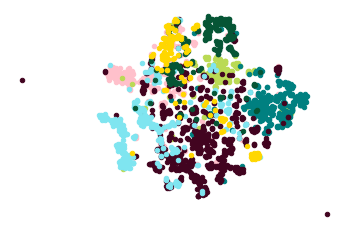

In [10]:
# PLOT 2D OF EMBEDDED REP 
@torch.no_grad() # Deactivate autograd functionality
def plot_point(colors):
    Node2Vec_model.eval() # Evaluate the model based on the trained parameters
    z = Node2Vec_model(torch.arange(data.num_nodes, device=device)) # Embedding rep
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()
    plt.figure()
    for i in range(dataset.num_classes):
        plt.scatter(z[y==i,0],z[y==i,1],s=20,color=colors[i])
    plt.axis('off')
    plt.show()
colors = [
        '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
        '#ffd700'
    ]
plot_point(colors)

In [11]:
# NODE CLASSIFICATION
def test():
    Node2Vec_model.eval() # Evaluate the model based on the trained parameters
    z = Node2Vec_model() # Evaluate the model based on the trained parameters
    acc = Node2Vec_model.test(z[data.train_mask] ,data.y[data.train_mask],
                              z[data.test_mask],data.y[data.test_mask],
                              max_iter=150)
    return acc

print('Accuracy:', test())

Accuracy: 0.715


In [ ]:
#From https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/node2vec.html
def test(self, train_z, train_y, test_z, test_y, solver='lbfgs',
             multi_class='auto', *args, **kwargs):
        r"""Evaluates latent space quality via a logistic regression downstream
        task."""
        from sklearn.linear_model import LogisticRegression

        clf = LogisticRegression(solver=solver, multi_class=multi_class, *args,
                                 **kwargs).fit(train_z.detach().cpu().numpy(),
                                               train_y.detach().cpu().numpy())
        return clf.score(test_z.detach().cpu().numpy(),
                         test_y.detach().cpu().numpy())